# PC Lab 3: Linear Regression
---

In [ ]:
!wget -c https://raw.githubusercontent.com/tfmortie/mlcourse/main/03_linear_regression/pc3.py -O pc3.py

--2024-01-29 21:18:55--  https://raw.githubusercontent.com/tfmortie/mlmust/main/03_linear_regression/pc3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



## 1. Introduction

The goal of linear regression is to model the relationship between one or more features *x* and a **continuous** variable *y*. When there is only one feature $x_1$ (univariate linear regression), the equation of the regression line is:

$$\hat{y} = w_{0} + w_{1}x_{1},$$

where $w_{0}$ is the intercept or bias. In case of multiple features, we talk about multiple linear regression, and $y$ is modelled as a linear combination of the features, weighted by some set of weights $\mathbf{w}$:

$$\hat{y} = w_{0}x_{0} + w_{1}x_{1} + ... + w_{p}x_{p} = \sum\limits_{i=0}^{p}w_{i}x_{i},$$

In this notation, we introduced an additional feature $x_{0}$ which always equals 1. This notation allows to formulate linear regression as a matrix multiplication:

$$\mathbf{\hat{y}} = \mathbf{X}\mathbf{w},$$

where $\mathbf{\hat{y}}$ (a vector of dimension $n \times 1$) contains the predicted target variable for the $n$ instances, $\mathbf{w}$ is a $p \times 1$ vector containing the weights and $\mathbf{X}$ is a $n \times (p+1)$ matrix with the features. Note that the first column of $\mathbf{X}$ is a column of ones, because it represents the feature $x_{0}$. We will stick to this matrix notation for the rest of this lab, as this notation is common practice in machine learning. Also, this notation makes it much easier to translate an algorithm into Python code.

Fitting this model to a dataset comes down to finding the weight vector $\mathbf{w}$ that minimizes the discrepancy between the true target values $\mathbf{y}$ and the predictions $\hat{\mathbf{y}}$. As is often the case in regression problems, this discrepancy between true values and predicted values is expressed by the **residual sum of squares (RSS)**:

$$RSS = \sum\limits_{i=1}^{n}(\hat{y}_{i} - y_{i})^2,$$

or, equivalently:

$$RSS = (\mathbf{y} - \mathbf{Xw})^{T}(\mathbf{y} - \mathbf{Xw}).$$

Note that the _mean squared error_ (MSE), as seen in the previous practical, is similar to RSS.

For most machine learning algorithms we need an optimization algorithm such as gradient descent to find the set of weights that minimize the discrepancy between true and predicted values. However, for linear regression there is a convenient analytical solution to find the optimal weight vector $\mathbf{w}$ that minimizes the RSS. This solution is obtained by solving the so-called normal equations, leading to the following expression:

$$\mathbf{w_{OLS}} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}.$$

This solution is called the ordinary least squares or OLS solution. With this equation in our toolbox, we can fit a linear regression model to a toy dataset. Let's illustrate this by means of a simple simulated dataset that consists of one feature $x$.

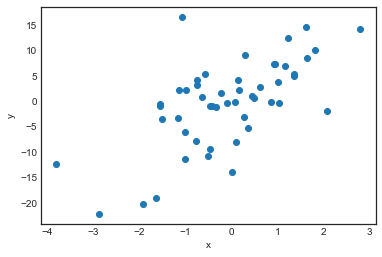

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

import pc3 as pc3 # some custom functions for this PC lab

n=50 # number of data points
x, y = pc3.simulate_linear_data(n=n, eps=6) # you can change the standard deviation of the noise

fig, ax = plt.subplots()
ax.scatter(x,y);
ax.set_xlabel('x');
ax.set_ylabel('y');

Now, let's use linear regression to model $y$ as a function of $x$. We can use the analytic result from the normal equations to find the optimal weight vector $\mathbf{w_{OLS}}$. For this, we will need the [np.linalg.inv()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) and [np.matmul()](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) functions in NumPy:

In [4]:
# Put the features in a matrix, with a column of ones for the intercept
X = np.ones((n,2))
X[:,1] = x

w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)),X.T),y)

In [5]:
w

array([0.1480758, 4.3185724])

We find the weight vector that minimizes the MSE between observations and predictions. With this weight matrix, we can estimate $y$ for the $x$'s in our dataset (or for any future value of $x$):

In [6]:
y_hat = np.matmul(X, w)

Now, let's visualize the regression line. 

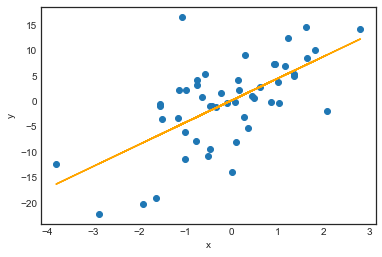

In [7]:
fig, ax = plt.subplots()
ax.scatter(x,y);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.plot(x, y_hat, color='orange');

We can evaluate the performance of our model by computing the MSE:

In [8]:
# Function to compute MSE
def compute_MSE(y_true, y_predicted):
    """Obtain MSE between true y's and predicted y's"""
    return(np.mean((y_true-y_predicted)**2))

MSE = compute_MSE(y, y_hat)
print('Mean squared error: {}'.format(MSE))

#Note that the vectorized notation would give the same result: MSE = np.dot(np.transpose(y_hat-y),(y_hat-y))/n

Mean squared error: 42.44641233353481


Obviously, this just reflects the performance of our model on the training data and we could get an arbitrarily low MSE by making our model more complex. In reality, we are more interested in the performance of our model on new, unseen data that was not used to train the model. We will illustrate this on a practical example.

## 2. Application: predicting house prices

We will use a [housing dataset](https://www.kaggle.com/harlfoxem/housesalesprediction) hosted on Kaggle for a practical illustration, slightly modified for the purpose of this PC lab. You can find the data in the file pc3_housingdata_modified.csv. The dataset contains the price of 21613 houses in US dollars, together with the following features:
1. **Categorical features** (take on one of a limited, and usually fixed, number of possible values): waterfront yes/no, color (yellow, blue, white or 'other').
2. **Ordinal features** (similar as categorical features, yet, equipped with a natural ordering): number of bedrooms, bathrooms, floors, yr_built.
3. **Continuous features**: surface areas: sqft_living, sqft_lot, sqft_above, sqft_basement, and latitude, longitude.

We would like to build a model that can predict the price of a house based on these features. First, let's read in the data:

In [ ]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/tfmortie/mlcourse/main/03_linear_regression/pc3_housingdata_modified.csv')
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,lat,long,color
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0,1955,47.5112,-122.257,yellow
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400,1951,47.7210,-122.319,other
2,180000.0,2,1.00,770,10000,1.0,0,770,0,1933,47.7379,-122.233,blue
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910,1965,47.5208,-122.393,yellow
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0,1987,47.6168,-122.045,other


In [10]:
len(data)

21613

Let's visualize some features to get an idea of what this data looks like:

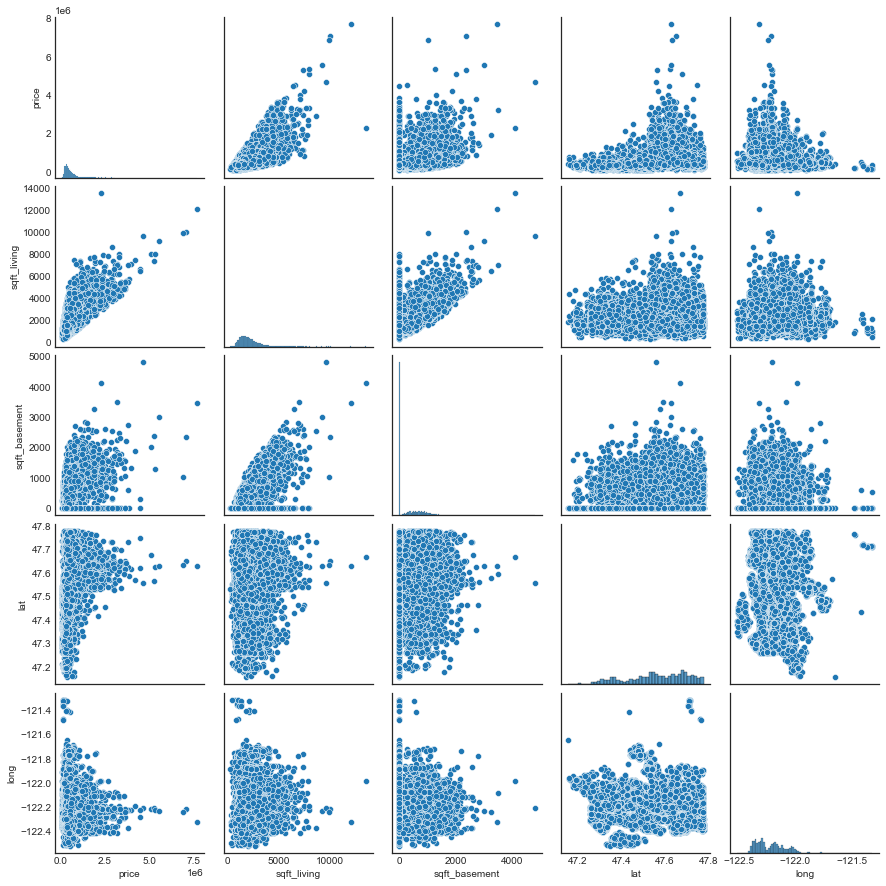

In [11]:
import seaborn as sns
sns.pairplot(data.loc[:,['price', 'sqft_living', 'sqft_basement', 'lat', 'long']])

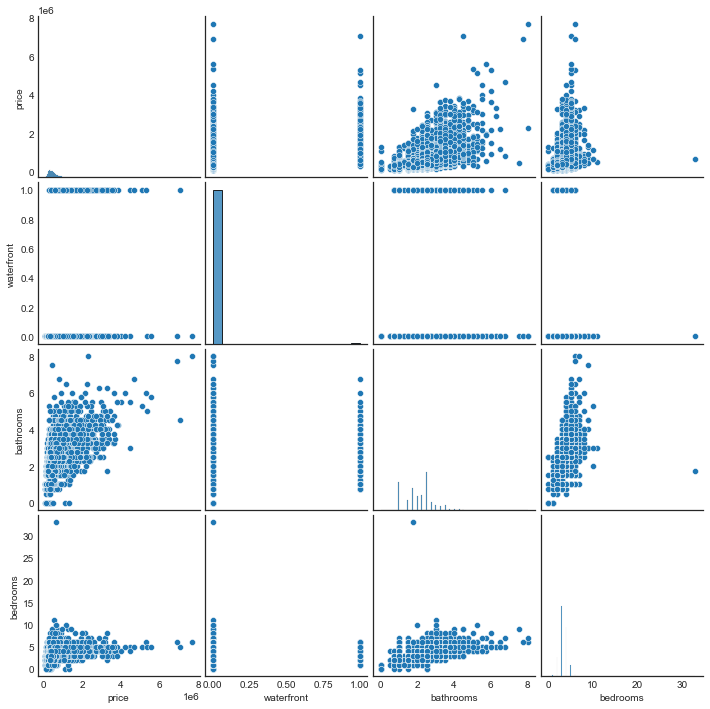

In [12]:
sns.pairplot(data.loc[:,['price','color', 'waterfront', 'bathrooms', 'bedrooms']])

There are different types of features here. How can we use the color attribute in a linear regression model? As seen in the previous practical, dummy variables can be used to encode categorical features. In machine learning, this is called **one-hot encoding**. As seen in the previous practical, both [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [Pandas](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) provide functions of that kind. Let's use Pandas, since it can handle text features:

In [13]:
dummies = pd.get_dummies(data.color)
dummies.head()

,blue,other,white,yellow
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,0,1
4,0,1,0,0


Let's add these encoded features to the dataframe:

In [14]:
data_onehot = pd.concat([data, dummies], axis=1)
data_onehot = data_onehot.drop(['color'], axis=1) # remove the original color column
data_onehot.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,lat,long,blue,other,white,yellow
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0,1955,47.5112,-122.257,0,0,0,1
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400,1951,47.7210,-122.319,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,0,770,0,1933,47.7379,-122.233,1,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910,1965,47.5208,-122.393,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0,1987,47.6168,-122.045,0,1,0,0


We can use these dummy variables in a linear regression model. First, it's good to extract the data from the Pandas dataframe into NumPy arrays, since most machine learning APIs are compatible with NumPy.

In [15]:
# Put data in numpy arrays
y = data_onehot.price.values
X = data_onehot.drop('price', axis=1).values

Finally, we would like to evaluate the performance of our data on new, unseen data, that was not used to train the model. Therefore, we split up our dataset into a training and a test dataset:

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) # Use 70% of data for training

<div class="alert alert-success">

<b>EXERCISE 2.1</b>: **Use the Scikit-learn Linear Regression implementation to fit a model on the housing dataset. Use the training data to fit the model. Compare the MSE of the model obtained on the training and on the test data, respectively. Finally, compute the coefficient of determination ($R^2$) on the test data. The relevant documentation page contains all the information that you need. Convenient methods that are defined in almost all Scikit-learn models are _fit()_, _predict()_ and _score()_.**     
</div>  


In [17]:
from sklearn.linear_model import LinearRegression


LinReg = LinearRegression() # call an instance of the class LinearRegression

LinReg.fit(X_train, y_train) # fit the model on the training data
y_hat_train = LinReg.predict(X_train) # predict training data
MSE_train = compute_MSE(y_train, y_hat_train) # Compute training set MSE

y_hat_test = LinReg.predict(X_test) # predict test data
MSE_test = compute_MSE(y_test, y_hat_test) # Test set MSE

R_train = LinReg.score(X_train, y_train) # Training set R²
R_test = LinReg.score(X_test, y_test) # Test set R²

print('Training set MSE: {}'.format(MSE_train))
print('Test set MSE: {}'.format(MSE_test))
print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))

Training set MSE: 49993474450.24368
Test set MSE: 43064398258.34923
Train set R²: 0.6445763416546648
Test set R²: 0.6441298352113116


## 3. Adding model flexibility: polynomial feature expansion

We can model non-linear relations by performing some non-linear transformation $\phi(\mathbf{x})$ on the original features $\mathbf{x}$. This is known as a **basis function expansion**. An example of such a transformation are polynomial basis functions, where we consider higher-order powers of the original features:

$$\phi(x) = [1, x, x^2, x^3,...,x^d].$$

It is important to note here that, although we use non-linear transformations, the model linear regression model $y = f(\phi(x)$ will still be linear in the parameters:

$$\hat{y} = w_{10}x_{0} + w_{11}x_{1} + w_{12}x_{1}^2 ... + w_{md}x_{m}^d.$$

This means that the solution will still be a line, be it in a transformed and typically higher-dimensional space instead of in the original feature space. This also means that we obtain the least-squares solutions just as we did earlier on.

With different feature expansions, we can strongly improve the performance of linear regression by taking into account interaction effects, quadratic or cubic effects... However, the risk of overfitting also increases! Let's go back to the simulation example. Instead of doing a simple linear regression, we will perform a polynomial feature expansion of the single feature:

In [18]:
import pc3 as pc3 # some custom functions for this PC lab
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

n=100 # number of data points 5000
eps=10 # amount of noise 20

x, y = pc3.simulate_linear_data(n=n, eps=eps) # you can change the standard deviation of the noise

In [19]:
# Put the features in a matrix, with a column of ones for the intercept. Add polynomial expansions.

# add x up to the 10th power
n_polynomials=20

X = np.ones((n,n_polynomials))
X[:,1] = x


for i in np.arange(2, n_polynomials):
    X[:,i] = x**i

<div class="alert alert-success">

<b>EXERCISE 3.1</b>: **Create the polynomial expansions of the original dataset using the [PolynomialFeatures()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) function from Scikit-learn. Use the fit and predict functions you used in the previous exercise to obtain the predictions $\hat{y}$.**     
</div>  

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=20)
poly.fit(x.reshape(-1, 1))
X = poly.transform(x.reshape(-1, 1))

LinReg = LinearRegression() # call an instance of the class LinearRegression

LinReg.fit(X, y) # fit the model on the training data

y_hat = LinReg.predict(X) # predict training data

Again, let's visualize the regression line:

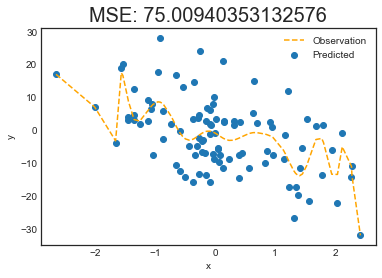

In [21]:
fig, ax = plt.subplots()
ax.scatter(x,y);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.plot(np.sort(x), y_hat[np.argsort(x)] , '--', color="orange");
ax.legend(['Observation', 'Predicted']);
ax.set_title('MSE: {}'.format(mean_squared_error(y, y_hat))).set_fontsize(20);

As can be seen above, expanding the polynomial up to the 20th power leads to a too complex model. **Remember that we simulated the data from an underlying linear relation between x and y!** This is a clear example of overfitting: by performing the polynomial expansion, our model becomes too flexible and fits to patterns in the data that, in reality, are just noise.

<div class="alert alert-success">

<b>OPTIONAL EXERCISE: Play with the parameters in the code above. Change the number of simulated data points from 50 to 100, 200, 500. What happens with the overfitting? Change the amount of noise.  Increase the size of the polynomial up to degree 12. Compare the MSE's. Try to understand the influence of each of these factors on the behavior of the model.</b>
</div>

By evaluating the performance of our model on a test set, we can check if we are overfitting or not. The following code simulates n data points from a linear model with noise. 50% of them are used to fit a linear regression model, with an increasing number of polynomial features. The other 50% data points are held out as a test set. For each model, the MSE on both the training and test data is evaluated. The plot shows the training and test MSE for increasing degrees of the polynomial expansion.

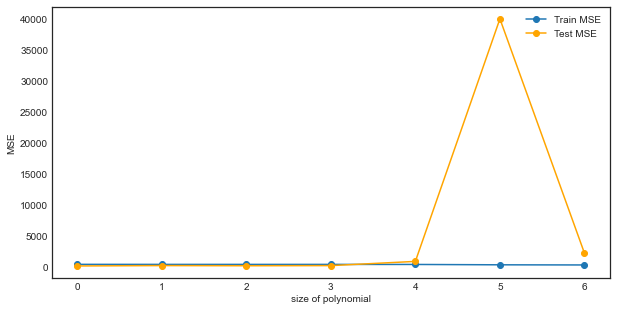

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

n=100
eps= 20
x, y = pc3.simulate_linear_data(n=n, eps=eps) # you can change the standard deviation of the noise

x_test, x_train = x[:n//4].reshape(-1, 1), x[n//4:].reshape(-1, 1)

y_test, y_train = y[:n//4].reshape(-1, 1), y[n//4:].reshape(-1, 1)

LinReg = LinearRegression()

MSE_train = []
MSE_test = []

for i in np.arange(1, 8):
    poly = PolynomialFeatures(degree=i)
    poly.fit(x_train)
    X_train = poly.transform(x_train)
    X_test = poly.transform(x_test)

    LinReg.fit(X_train,y_train.reshape(-1,1))
    pred_train = LinReg.predict(X_train)
    pred_test = LinReg.predict(X_test)
    MSE_train.append(mean_squared_error(y_train, pred_train))
    MSE_test.append(mean_squared_error(y_test, pred_test))


fig, ax = plt.subplots(figsize=(10,5))
pd.Series(MSE_train).plot(ax=ax, marker='o');
pd.Series(MSE_test).plot(ax=ax, marker='o', color='orange');
ax.legend(['Train MSE', 'Test MSE']);
ax.set_xlabel('size of polynomial');
ax.set_ylabel('MSE');

<div class="alert alert-success">

<b>OPTIONAL EXERCISE: Describe what you see. What happens with the training MSE as you increase the number of features? What happens with the test MSE? How can you explain this?</b>
</div>

<div class="alert alert-success">

<b>OPTIONAL EXERCISE: Try to improve the performance of the linear model for the housing dataset by expanding the feature space. Scikit-learn has a method to expand a NumPy array with polynomial features. Keep an eye on overfitting!</b>
</div>

In [23]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/diliadis/UGain_linreg/main/pc3_housingdata_modified.csv')
dummies = pd.get_dummies(data.color)
data_onehot = pd.concat([data, dummies], axis=1)
data_onehot = data_onehot.drop(['color'], axis=1) # remove the original color column
data_onehot.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,lat,long,blue,other,white,yellow
0,221900.0,3,1.00,1180,5650,1.0,0,1180,0,1955,47.5112,-122.257,0,0,0,1
1,538000.0,3,2.25,2570,7242,2.0,0,2170,400,1951,47.7210,-122.319,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,0,770,0,1933,47.7379,-122.233,1,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,0,1050,910,1965,47.5208,-122.393,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,0,1680,0,1987,47.6168,-122.045,0,1,0,0


In [24]:
# Put data in numpy arrays
y = data_onehot.price.values
X = data_onehot.drop('price', axis=1).values

In [25]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=True, interaction_only=False)
X = poly.fit_transform(X)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) # Use 70% of data for training

In [27]:
from sklearn.linear_model import LinearRegression

LinReg = LinearRegression() # call an instance of the class LinearRegression

LinReg.fit(X_train, y_train) # fit the model on the training data
y_hat_train = LinReg.predict(X_train) # predict training data
MSE_train = mean_squared_error(y_train, y_hat_train) # Compute training set MSE

y_hat_test = LinReg.predict(X_test) # predict test data
MSE_test = mean_squared_error(y_test, y_hat_test) # Test set MSE

R_train = LinReg.score(X_train, y_train) # Training set R²
R_test = LinReg.score(X_test, y_test) # Test set R²

print('Training set MSE: {}'.format(MSE_train))
print('Test set MSE: {}'.format(MSE_test))
print('Train set R²: {}'.format(R_train))
print('Test set R²: {}'.format(R_test))

Training set MSE: 33750650872.466324
Test set MSE: 39445492393.73583
Train set R²: 0.7381593705567177
Test set R²: 0.7343535899709671
